# Introduction
This is a document explaining how to produce $\chi^2$ flags for RFI from a starting point of MWA correlator FITS files. 
This was roughly the procedure I followed to produce the $\chi^2$ flags in my paper.

The cells in Jupyter notebook are intended to be run in the order in which they are presented.

# Prerequisites

You'll need `pyuvdata` (https://github.com/RadioAstronomySoftwareGroup/pyuvdata/) and `hera_cal` (https://github.com/HERA-Team/hera_cal) installed, and obviously all of *their* prerequisites.
You will also need the h5py library, available through `conda` or `pip`.
For this notebook in particular, you will need matplotlib.
**You'll also need to get your hands on my `chisq_flagging.py` file which has the z-score statistics and flagging algorithm functions that I used.**

In [45]:
import numpy as np
import numpy.ma as ma
import glob
import h5py
from pyuvdata import UVData
from matplotlib import pyplot as plt
from hera_cal.io import HERAData, HERACal
from hera_cal.redcal import redcal_run
from chisq_flagging import watershed

# Obtain MWA correlator FITS files

Go to ASVO at https://asvo.mwatelescope.org and find the data you want to work with.
Right now, the ASVO website is down, so I can't provide exact instructions.
For the time being, let's assume you've obtained the files in question, which (for one observation) should have 24 filenames of the form `{obsid}_{date_string}_gpubox{channel_num}_{NUM}.fits` (containing the data), and `{obsid}_flags.zip` containing the AOFlagger flags, which unzip to 24 .mwaf files labelled as `{obsid}_{channel_num}.mwaf`.

# Perform some preliminary setup

`directory` is the path to the directory with your data files.
`out_directory` is the path to which you'll be writing .h5 files storing your $\chi^2$ values if you choose to do so.
`intermediate_directory` is the path to a directory where you can store intermediate files. You probably won't need these later, so feel free to redirect this to your scratch folder.

`obsid` is the OBServation IDentification number of the data you are reading in.

In [31]:
directory = '/users/tkunicki/data/tkunicki/full_download/'
out_directory = '/users/tkunicki/data/tkunicki/chisqs2/'
intermediate_directory = '/users/tkunicki/data/tkunicki/intermediate_files/'

In [16]:
obsid = 1161886488

# Read MWA data into a UVData object

Use `pyuvdata` to read in the MWA correlator FITS files as follows:
1. make an empty UVData object: 

In [17]:
uvd = UVData()

2. use `glob` to pattern match all of the corr fits files for your obsid: 

In [18]:
files = glob.glob(directory+str(obsid)+'*fits')

3. Read in the data, and set the `x_orientation` of the object to "east":

In [20]:
uvd.read_mwa_corr_fits(files, use_aoflagger_flags=False, flag_init=True)
uvd.x_orientation = 'east'

cable length correction is now defaulted to True rather than False. To read in files without applying the correction set correct_cable_len=False. This warning will be removed in v2.4


# Process the UVData object

1. Select down to only the antennas within the two redundant hexagons of the MWA:

In [22]:
ants = np.unique(uvd.ant_1_array)
ants = np.array([ant for ant in ants if ant > 1000])
uvd.select(antenna_nums=ants, keep_all_metadata=False)

This uses the fact that the antenna numbers of all the hex antennas are over 1000. However, if you aren't starting with the MWA correlator FITS files but from uvfits files or something, you may run into a different antenna numbering system where no antennas have a number greater than 1000.
It's technically the difference between antenna number and tile number.
I hope this note saves some anguish in the future.

2. Downsample in time

In [23]:
uvd.downsample_in_time(n_times_to_avg=9, keep_ragged=False)

Data are unprojected or phased as a driftscan, phasing before resampling.
Undoing phasing.


I settled on `n_times_to_avg = 9` as being the best for my dataset (which has `Ntimes = 56` to start with), but feel free to experiment with this parameter.

3. Save the processed UVData object to an intermediate `uvh5` file.

In [24]:
uvd.write_uvh5(intermediate_directory + str(obsid) + '.uvh5', clobber=True)

File exists; clobbering


# Run HERA_cal

1. Make a `HERAdata` object by reading from the intermediate file:

In [25]:
hd = HERAData(intermediate_directory + str(obsid) + '.uvh5')

2. Run redundant calibration:

In [26]:
redcal_meta, hc_first, hc_omni, hd_vissol = redcal_run(hd, verbose=True, clobber=True, 
                                                       max_dims=3, ex_ants=[], oc_conv_crit=1e-10, 
                                                       oc_maxiter=2000, check_every=10, check_after=500, 
                                                       ant_z_thresh=100.0, gain=0.3, solar_horizon=90.0)


Now running redundant calibration without antennas [] ...
Now calibrating ['ee'] polarization(s)...
    Now calibrating times 2457692.2601851854 through 2457692.261226852 ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457692.2601851854 through 2457692.261226852 ...
File exists; clobbering


This function has tons of parameters, which are explored in detail in an appendix of my paper. 
The most important parameters to maintain are `max_dims = 3` and `ant_z_thresh = 100.0`. `max_dims=3` guarantees that we have the right number degrees of freedom (there is an extra one for the phase delay between the hexes), and `ant_z_thresh=100.0` guarantees that none of the antennas are thrown out of the calibration due to having a
high z-score. 
If there’s a way to turn off that functionality more elegantly, I still haven’t found it.

3. Extract important data from the `hc_omni` object (which stores information about the omnical run, including $\chi^2$.

In [27]:
gains, flags_cal, quals, total_qual = hc_omni.build_calcontainers()

# Produce a masked version of $\chi^2$ values, and normalize

1. Construct a mask, where the mask corresponds to the MWA course band structure.

In [28]:
band_edges = uvd.get_flags(1001, 1002)[:,:,0]
band_edges = np.zeros(band_edges.shape, dtype=bool)

for row in band_edges:
    for i, element in enumerate(row):
        remainder = i%32
        if remainder in [0, 1, 16, 30, 31]:
            row[i] = True

2. make a masked version of `total_qual`, and call it `m_total_qual`:

In [29]:
m_total_qual = {}
for pol in total_qual:
    m_total_qual[pol] = ma.masked_array(total_qual[pol], mask=band_edges)

3. In order to normalize our masked $\chi^2$ values, We are going to multiply element-wise by the original downsampled and antenna-selected `UVData` object's `nsamples_array`. The logic behind this normalization is in Appendix 1.1 of my paper.

In [33]:
m_total_qual_normalized = {}
for pol in m_total_qual:
    m_total_qual_normalized[pol] = (m_total_qual[pol] * uvd.get_nsamples((1001,1002,'ee')))

# Make an .h5 file and store $\chi^2$ values on disk (optional)

This step is optional, and only needed if you're running this as a batch operation and/or need to save your $\chi^2$ values to disk.

In [37]:
with h5py.File(f'{out_directory}{obsid}.h5', 'w') as f:
    group = f.create_group('chisqs')
    for key, value in m_total_qual_normalized.items():
        group.create_dataset(key, data=value)

The .h5 files I have stored on disk on OSCAR are a little more complex; let me break down their contents. Here is a list of the keys to each file:
-  chisqs: the `m_total_qual_normalized` dictionary as described above. Has `'Jee'` and `'Jnn'` subkeys, for either polarization.
-  flags: outdated, bad flags, determined with a simple modified z-score threshold. Do NOT use these flags. Has `'Jee'` and `'Jnn'` subkeys, for either polarization.
-  lsts: the local sidereal times of the correlator data.
-  mjd: the modified Julian date of the file's start time.
-  gridname: the name of the grid being used for pointing.
-  gridnum: the gridpoint number of the pointing.
-  mean: the mean of the normalized, masked $\chi^2$ values. Has `'Jee'` and `'Jnn'` subkeys, for either polarization.
-  std: the standard deviation of the normalized, masked $\chi^2$ values. Has `'Jee'` and `'Jnn'` subkeys, for either polarization.
-  skew: the skew of the normalized, masked $\chi^2$ values. Has `'Jee'` and `'Jnn'` subkeys, for either polarization.
-  kurtosis: the kurtosis of the normalized, masked $\chi^2$ values. Has `'Jee'` and `'Jnn'` subkeys, for either polarization.

# Reconstitute your $\chi^2$ values from the .h5 object (optional)

If you are working with stored $\chi^2$ values from an .h5 file, the first step is turning the data back into a numpy masked array.
This step is *unnecessary* if you still have the `m_total_qual_normalized` object in memory.

In [38]:
with h5py.File(f'{out_directory}{obsid}.h5', 'r') as f:
    m_total_qual_normalized = {}
    for pol in f['chisqs'].keys():
        m_total_qual_normalized[pol] = ma.masked_array(f['chisqs'][pol], mask=band_edges)

If necessary, you may have to rebuild the `band_edges` array as above.

# Generate flags from $\chi^2$ values

Using the function in `chisq_flagging.py`, generate flags from the two-step flagging process detailed in my paper (first iterative modified z-score flagging, then modified watershed flagging).

In [39]:
chisq_flags = watershed(m_total_qual_normalized)

If the dict is in the right format (i.e., it has two keys, `'Jee'` and `'Jnn'` corresponding to both polarizations), this should work without complaint. If you are running this from the Jupyter notebook, the dict really *should* be in the right format without trying too hard.

You are left with a dict of masked arrays, `chisq_flags`, where the flags are the sum of both the corrupted coarse band channels and the flags from two-step $\chi^2$ flagging.

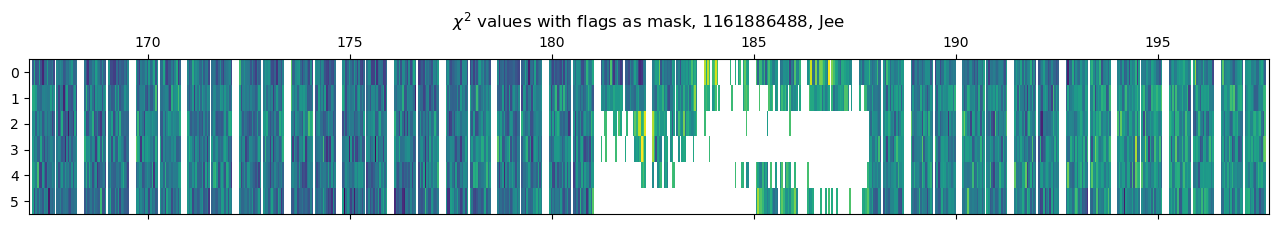

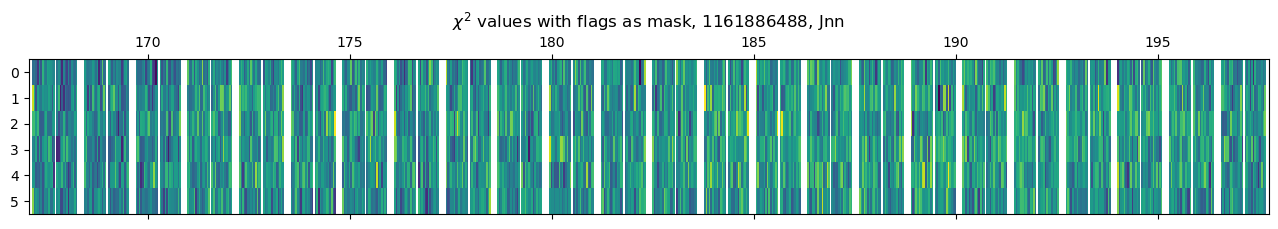

In [58]:
for pol in chisq_flags:
    plt.matshow(chisq_flags[pol], aspect='auto', extent=[167.055, 197.735, 5.5, -0.5])
    plt.title(f'$\chi^2$ values with flags as mask, {obsid}, {pol}')
    plt.ylabel('time bin')
    plt.xlabel('frequency (MHz)')

If you want to study the flags directly, use:

In [62]:
flags = {}
for pol in chisq_flags:
    flags[pol] = chisq_flags[pol].mask

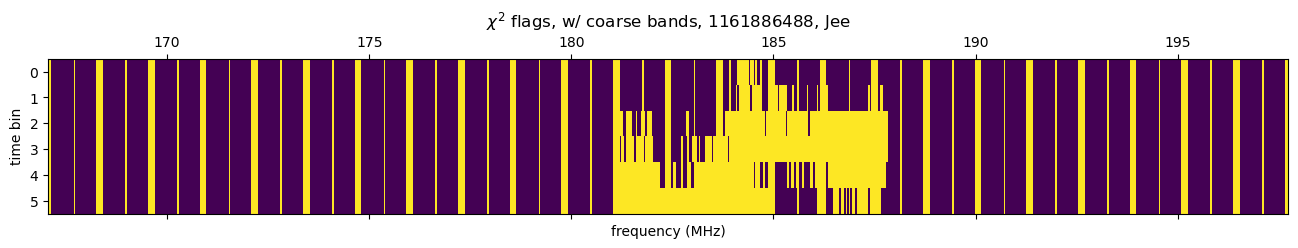

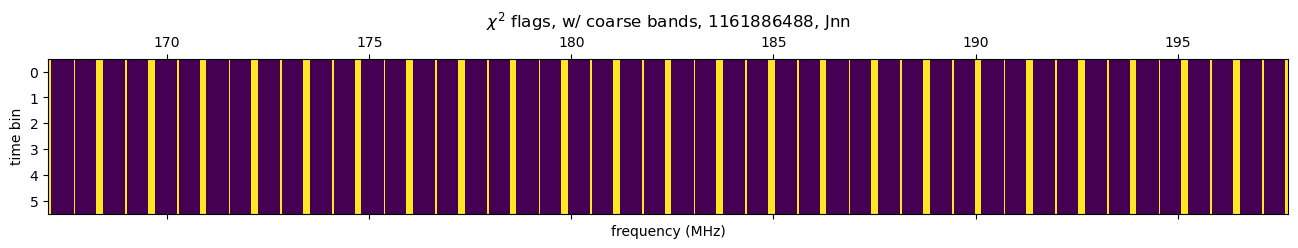

In [64]:
for pol in flags:
    plt.matshow(flags[pol], aspect='auto', extent=[167.055, 197.735, 5.5, -0.5])
    plt.title(f'$\chi^2$ flags, w/ coarse bands, {obsid}, {pol}')
    plt.ylabel('time bin')
    plt.xlabel('frequency (MHz)')

If you want to get rid of the coarse band flags and only see the flags from $\chi^2$, simply subtract the band flag structure from the flags:

In [53]:
flags_wo_band_edges = {}
for pol in chisq_flags:
    flags_wo_band_edges[pol] = chisq_flags[pol].mask ^ band_edges

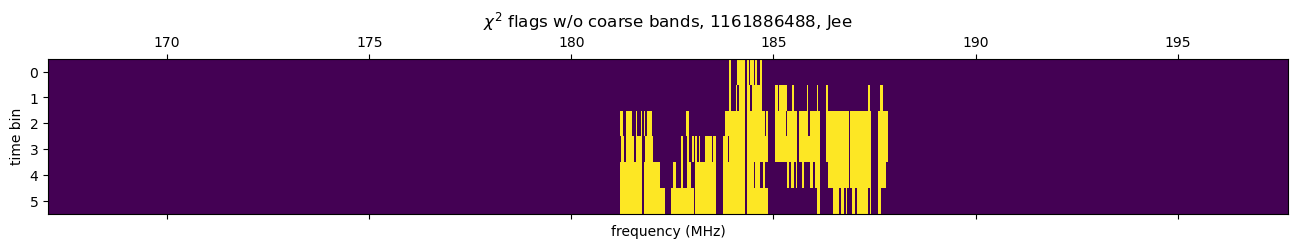

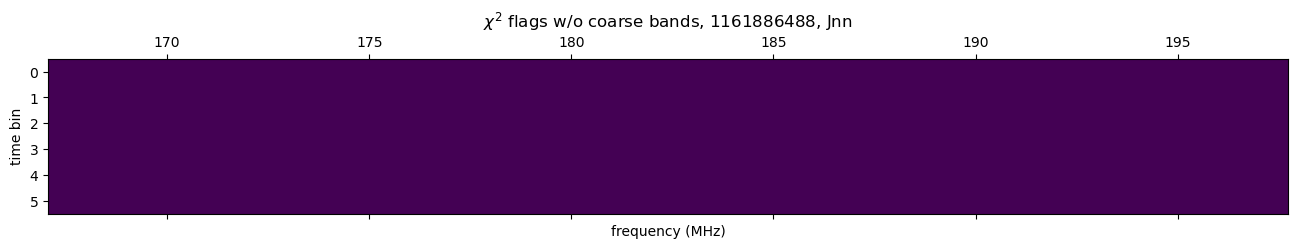

In [65]:
for pol in flags_wo_band_edges:
    plt.matshow(flags_wo_band_edges[pol], aspect='auto', extent=[167.055, 197.735, 5.5, -0.5])
    plt.title(f'$\chi^2$ flags w/o coarse bands, {obsid}, {pol}')
    plt.ylabel('time bin')
    plt.xlabel('frequency (MHz)')

# Enjoy your $\chi^2$ flags!